In [1]:
import pandas as pd
import os
import glob
from tqdm import tqdm
import math
from rake_nltk import Rake
from transformers import pipeline
import warnings

#Refactored code new time 18s from 220s
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import time

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

/home/krish/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /home/krish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/krish/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/krish/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [57]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
final_df = pd.DataFrame(columns=["reviews"])

In [4]:
path = r"reviews/*.csv"

def preprocess_text(text):
    #Function taken from (https://stackoverflow.com/a/71095469/14204371)

    text = text.lower()
    text = re.sub('[^a-zA-Z]', ' ', text)

    stopwords_dict = {word: 1 for word in stopwords.words("english")}
    text = " ".join([word for word in text.split() if word not in stopwords_dict])

    text = ' '.join([lemmatizer.lemmatize(w) for w in text.split()])
    return text


for fname in glob.glob(path):
    print(fname)

    df = pd.read_csv(fname)
    sentiment_pipeline = pipeline("sentiment-analysis")
    sentiment_score = [sentiment_pipeline(df.iloc[i].values[0])[0]['label'] for i in range(len(df))]    
    sentiment_dict = {'sentiment': sentiment_score}    

    keywords = []
    for i in tqdm(range(len(df))):
        r = Rake()
        r.extract_keywords_from_text(df['reviews'].iloc[i])
        phrases = r.get_ranked_phrases()
        keywords.append(phrases[:math.floor(len(phrases)*0.4)])
    
    key_dict = {'keywords': keywords}
    
    df = pd.concat([df, pd.DataFrame(key_dict), pd.DataFrame(sentiment_dict)], axis=1)
    
    final_df = pd.concat([final_df, df], axis=0, ignore_index=True)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


reviews/cardekhoReviews.csv


100%|█████████████████████████████████████████████████████████████████████████████████| 1059/1059 [00:01<00:00, 1019.31it/s]
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


reviews/tigor_ev.csv


100%|█████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 1735.54it/s]
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


reviews/carwale_nexon.csv


100%|█████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 1095.47it/s]
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


reviews/hyundai_kona_reviews.csv


100%|█████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 2737.94it/s]
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


reviews/TataNexonCardekhoReviews.csv


100%|█████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 2555.50it/s]
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


reviews/carwale_hyundai_kona.csv


100%|█████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 2204.76it/s]


In [117]:
reviews = np.concatenate(final_df[final_df['sentiment'] == 'POSITIVE']['keywords'].values)

In [118]:
candidates=list(set(reviews))

# KeyBert

In [53]:
from keybert import KeyBERT
kw_model = KeyBERT()

In [92]:
keywords = kw_model.extract_keywords(final_df['reviews'].values[0], final_df['keywords'].values[0])

In [242]:
kw_model.extract_keywords(final_df['reviews'].values[19], keyphrase_ngram_range=(3, 3), stop_words='english')

[('best vehicle market', 0.6256),
 ('ev sector great', 0.6125),
 ('market currently ev', 0.5645),
 ('driving range good', 0.5415),
 ('currently ev sector', 0.5348)]

In [274]:
cols = ['battery', 'mileage', 'charging', 'interior', 'exterior', 'comfort', 'safety', 'quality', 'performance', 'sound',
        'efficiency', 'engine', 'affordable', 'cost']

In [272]:
from collections import Counter

keywords = []
for i in range(len(df)):
    result = kw_model.extract_keywords(final_df[final_df['sentiment'] == 'POSITIVE']['reviews'].values[i], keyphrase_ngram_range=(1, 1), stop_words='english')
    for res in result:
        key, score = res
        # print(key)
        keywords.append(key)

positive = dict(Counter(keywords))        

In [296]:
sorted(zip(positive.values(), positive.keys()))[::-1]

[(22, 'car'),
 (10, 'performance'),
 (8, 'ev'),
 (8, 'electric'),
 (7, 'mileage'),
 (7, 'drive'),
 (6, 'driving'),
 (6, 'cars'),
 (5, 'vehicle'),
 (5, 'tata'),
 (5, 'interior'),
 (4, 'interiors'),
 (4, 'comfortable'),
 (4, 'comfort'),
 (3, 'stylish'),
 (3, 'quality'),
 (3, 'nexon'),
 (3, 'evs'),
 (3, 'battery'),
 (2, 'suggest'),
 (2, 'specifications'),
 (2, 'sound'),
 (2, 'seats'),
 (2, 'safety'),
 (2, 'price'),
 (2, 'overall'),
 (2, 'middle'),
 (2, 'looks'),
 (2, 'indian'),
 (2, 'features'),
 (2, 'exterior'),
 (2, 'efficiency'),
 (2, 'budget'),
 (2, 'brand'),
 (2, 'attractive'),
 (2, 'airbags'),
 (2, 'affordable'),
 (2, '20l'),
 (1, 'ultimate'),
 (1, 'tiger'),
 (1, 'running'),
 (1, 'reviews'),
 (1, 'market'),
 (1, 'km'),
 (1, 'engine'),
 (1, 'cost'),
 (1, 'compared'),
 (1, 'charging'),
 (1, 'ac'),
 (1, '220')]

In [322]:
from collections import Counter

keywords=[]
for i in range(len(df)):
    result = kw_model.extract_keywords(final_df[final_df['sentiment'] == 'NEGATIVE']['reviews'].values[i], keyphrase_ngram_range=(1, 1), stop_words='english')
    for res in result:
        key, score = res
        keywords.append(key)

negatives = dict(Counter(keywords))        

In [323]:
sorted(zip(negatives.values(), negatives.keys()))[::-1]

[(20, 'ev'),
 (18, 'battery'),
 (8, 'nexon'),
 (8, 'charging'),
 (8, 'car'),
 (7, 'tata'),
 (7, 'service'),
 (7, 'km'),
 (4, 'vehicles'),
 (4, 'vehicle'),
 (4, 'sbm'),
 (4, 'rupees'),
 (4, 'rs3600'),
 (4, 'purchasing'),
 (4, 'petrol'),
 (4, 'percentage'),
 (4, 'mileage'),
 (4, 'dropping'),
 (4, 'drive'),
 (4, 'discharging'),
 (4, 'cars'),
 (4, '89km'),
 (4, '312km'),
 (4, '312'),
 (4, '190km'),
 (4, '125km'),
 (3, 'range'),
 (3, 'pickup'),
 (3, 'electric'),
 (3, 'charge'),
 (3, 'automatic')]

In [ ]:
# mileage, range, dealer, battery, service, service charge

In [324]:
# final_df[final_df['sentiment'] == 'NEGATIVE']['reviews'].values

# Wordcloud

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

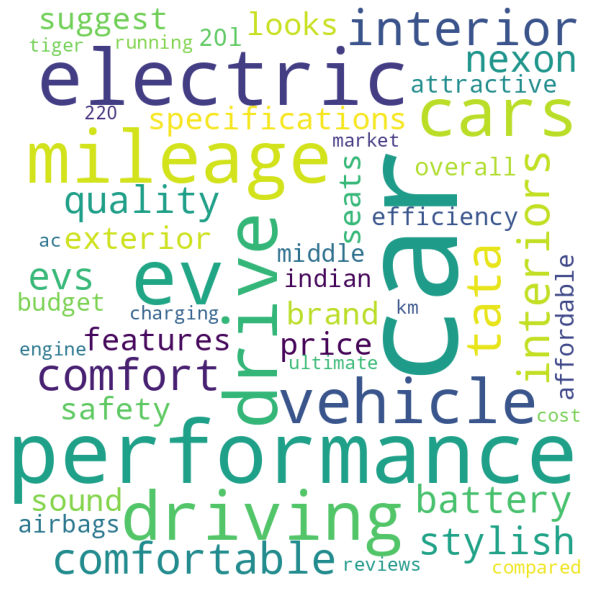

In [275]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(counts) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

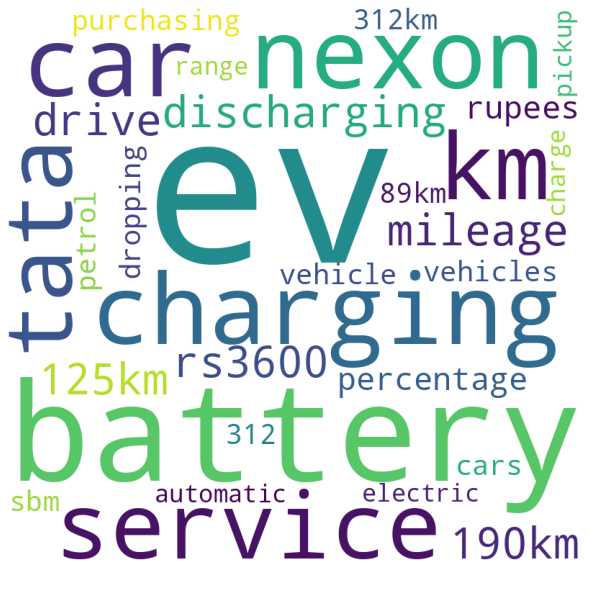

In [325]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(negatives) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 